# Keras for Text Classification

## Learning Objectives
1. Learn how to create a text classification datasets using BigQuery.
1. Learn how to tokenize and integerize a corpus of text for training in Keras.
1. Learn how to do one-hot-encodings in Keras.
1. Learn how to use embedding layers to represent words in Keras.
1. Learn about the bag-of-word representation for sentences.
1. Learn how to use DNN/CNN/RNN model to classify text in keras.

## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset we constructed in the first task of the lab.

In the next step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to split them into a list of tokens, and then how to map each token to an integer using the Keras Tokenizer class. What will be fed to our Keras models will be batches of padded list of integers representing the text. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification. All models will be fed padded list of integers, and all models will start with a Keras Embedding layer that transforms the integer representing the words into dense vectors.

The first model will be a simple bag-of-word DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). In the second and in the third model we will keep the information about the word order using a simple RNN and a simple CNN allowing us to achieve the same performance as with the DNN model but in much fewer epochs.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/keras_for_text_classification.ipynb).

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = "qwiklabs-gcp-03-8fdabaee4f9a"  # Replace with your PROJECT
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION
SEED = 0

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://console.cloud.google.com/bigquery?project=bigquery-public-data&page=table&t=full&d=hacker_news&p=bigquery-public-data&redirect_from_classic=true) contains all headlines from the sites inception in October 2006 until October 2015. 

### Lab Task 1a: 
Complete the query below to create a sample dataset containing the `url`, `title`, and `score` of articles from the public dataset `bigquery-public-data.hacker_news.full`. Use a WHERE clause to restrict to only those articles with
* title length greater than 10 characters
* score greater than 10
* url length greater than 0 characters

In [4]:
%%bigquery --project $PROJECT

SELECT
    url,
    title,
    score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10


Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,url,title,score
0,https://semiwiki.com/semiconductor-manufacture...,Intel 4 Deep Dive,16
1,https://github.com/speakeasy-api/rest-template-go,Show HN: A RESTful API Template in Go,11
2,https://blog.clubhouse.com/dynamite-our-client...,"Dynamite, our client library for using DynamoD...",12
3,https://www.infoworld.com/article/3668197/how-...,"Cloudflare emerged to take on AWS, Azure, and GCP",21
4,https://sourceware.org/pipermail/libc-alpha/20...,glibc – GNU C Library 2.36,35
5,https://www.engadget.com/sec-cryptocurrency-po...,SEC charges 11 people over 'textbook' $300M cr...,21
6,https://twitter.com/davidrowley_pg/status/1554...,Performance of ORDER BY / DISTINCT has been te...,16
7,https://www.bloomberg.com/news/features/2022-0...,"Goldman accuses developers of theft, damages c...",11
8,https://www.theguardian.com/us-news/2022/aug/0...,Polio found in New York wastewater month befor...,15
9,https://publicintegrity.org/inside-publici/new...,Postal workers go into debt when management cl...,19


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

### Lab task 1b:
Complete the query below to count the number of titles within each 'source' category. Note that to grab the 'source' of the article we use the a regex command on the `url` of the article. To count the number of articles you'll use a `GROUP BY` in sql, and we'll also restrict our attention to only those articles whose title has greater than 10 characters.

In [5]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source,
    COUNT(*) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
LIMIT 100


Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,source,num_articles
0,github,178379
1,medium,133550
2,youtube,126909
3,nytimes,83662
4,blogspot,61890
...,...,...
95,itworld,3161
96,nextplatform,3119
97,atlasobscura,3058
98,anandtech,3011


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,title,source
0,sencha touch 2 community patches,github
1,node.js sendfile http fileserver - fast and ...,github
2,theengs openmqttgateway mqtt gateway for esp8...,github
3,phoddie node-red-mcu experimental node-red im...,github
4,cheerio - fast flexible and lean implementat...,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [8]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 321262 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

source
github        178379
nytimes        83662
techcrunch     59221
Name: count, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [10]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [11]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

### Lab Task 1c:
Use `.sample` to create a sample dataset of 1,000 articles from the full dataset. Use `.value_counts` to see how many articles are contained in each of the three source categories?

In [13]:
sample_title_dataset = title_dataset.sample(n=1000, random_state=42)# TODO: Your code goes here.
source_counts = sample_title_dataset['source'].value_counts() # TODO: Your code goes here.
print(source_counts)

source
github        542
nytimes       262
techcrunch    196
Name: count, dtype: int64


Let's write the sample datatset to disk.

In [14]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [15]:
sample_title_dataset.head()

,title,source
305033,ready to rumble here s who microsoft will bri...,techcrunch
134539,stacktable.js - a jquery plugin for stacking t...,github
137186,swirl ai search through multiple data sources...,github
311238,uber eats exits seven markets transfers one a...,techcrunch
33445,show hn llm react node app template,github


In [16]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2025-04-16 21:24:08.769984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 21:24:09.060151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 21:24:09.128531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 21:24:09.674116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0


In [17]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [18]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times).

In [19]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,node version management,github
1,what soldiers eat by country,nytimes
2,ph7builder an open source social dating cms,github
3,interview with facebook s joe hewitt iphone god,techcrunch
4,how jeff bezos iphone x was hacked,nytimes


## Integerize the texts

The first thing we need to do is to find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with that:

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

In [21]:
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)
integerized_titles[:3]

[[63, 270, 202],
 [59, 6416, 2384, 29, 1379],
 [35747, 15, 18, 19, 143, 2126, 1578]]

In [22]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

103433

In [23]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

321262

In [24]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

Let's now implement a function `create_sequence` that will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

### Lab Task #2:
Complete the code in the `create_sequences` function below to
* create text sequences from `texts` using the tokenizer we created above 
* pad the end of those text sequences to have length `max_len`

In [27]:
# TODO 1
def create_sequences(texts, max_len=MAX_LEN):
    
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences


In [28]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[   63,   270,   202,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   59,  6416,  2384,    29,  1379,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [35747,    15,    18,    19,   143,  2126,  1578,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [29]:
titles_df.source[:4]

0        github
1       nytimes
2        github
3    techcrunch
Name: source, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [30]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

### Lab Task #3:
Complete the code in the `encode_labels` function below to
* create a list that maps each `source` in `sources` to its corresponding numeric value using the dictionary `CLASSES` above
* use the Keras function to one-hot encode the variable classes

In [31]:
# TODO 2

def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]# TODO: Your code goes here.
    one_hots = to_categorical(classes)  # TODO: Your code goes here.   
    return one_hots

In [32]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Preparing the train/test splits

Let's split our data into train and test splits:

In [33]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [34]:
sources_train.value_counts()

source
github        142644
nytimes        66998
techcrunch     47367
Name: count, dtype: int64

In [35]:
sources_valid.value_counts()

source
github        35735
nytimes       16664
techcrunch    11854
Name: count, dtype: int64

Using `create_sequence` and `encode_labels`, we can now prepare the
training and validation data to feed our models.

The features will be
padded list of integers and the labels will be one-hot-encoded 3D vectors.

In [36]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [37]:
X_train[:3]

array([[   63,   270,   202,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   59,  6416,  2384,    29,  1379,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [35747,    15,    18,    19,   143,  2126,  1578,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [38]:
Y_train[:3]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

### Lab Tasks #4, #5, and #6:
Create a Keras Sequential model with three layers:
* The first layer should be an embedding layer with output dimension equal to `embed_dim`.
* The second layer should use a Lambda layer to create a bag-of-words representation of the sentences by computing the mean.
* The last layer should use a Dense layer to predict which class the example belongs to.

In [41]:
# TODOs 4-6
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Lambda

def build_dnn_model(embed_dim):
    
    model = Sequential([
        # Layer 1: Embedding layer to transform word integers into dense vectors
        Embedding(input_dim=len(tokenizer.word_index) + 1,  # Vocabulary size + 1 (for padding)
                  output_dim=embed_dim),                    # Dimension of embedding vectors
                  # Remove input_length as it's deprecated
        
        # Layer 2: Lambda layer to create bag-of-words representation (mean of word vectors)
        Lambda(lambda x: K.mean(x, axis=1)),
        
        # Layer 3: Dense layer with softmax activation for classification
        Dense(len(CLASSES), activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

Epoch 1/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6039 - loss: 0.8497 - val_accuracy: 0.7627 - val_loss: 0.5439
Epoch 2/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7856 - loss: 0.5010 - val_accuracy: 0.8527 - val_loss: 0.4063
Epoch 3/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8629 - loss: 0.3757 - val_accuracy: 0.8749 - val_loss: 0.3378
Epoch 4/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8845 - loss: 0.3117 - val_accuracy: 0.8853 - val_loss: 0.3053
Epoch 5/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8966 - loss: 0.2768 - val_accuracy: 0.8910 - val_loss: 0.2868
Epoch 6/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9050 - loss: 0.2536 - val_accuracy: 0.8949 - val_loss: 0.2749
Epoch 7/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9112 - loss: 0.2365 - val_accuracy: 0.8980 - val_loss: 0.2669
Epoch 8/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9165 - loss: 0.2229 - val_accu

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 26, 10)         │     1,034,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,103,121 (11.84 MB)

 Trainable params: 1,034,373 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,068,748 (7.89 MB)

CPU times: user 3min 6s, sys: 14 s, total: 3min 20s
Wall time: 1min 27s


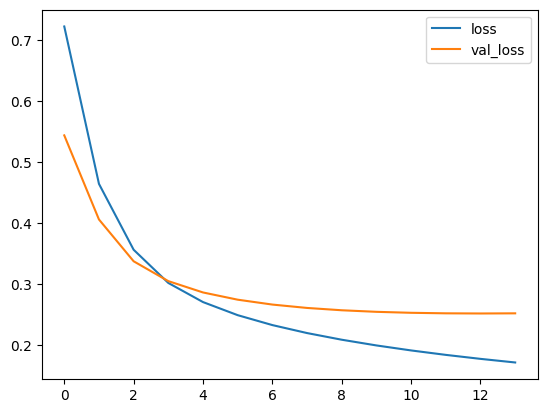

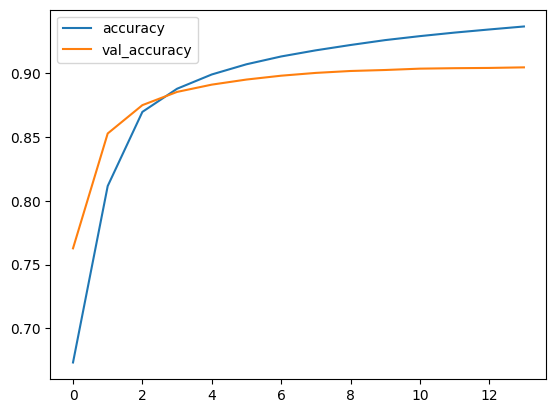

In [42]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

## Building a RNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple RNN model with a single `GRU` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


### Lab Task #4 and #6:
Complete the code below to build an RNN model which predicts the article class. The code below is similar to the DNN you created above; however, here we do not need to use a bag-of-words representation of the sentence. Instead, you can pass the embedding layer directly to an RNN/LSTM/GRU layer.

In [43]:
def build_rnn_model(embed_dim, units):
    
    model = Sequential([
        # Embedding layer to transform word integers into dense vectors
        # Setting mask_zero=True to ignore padded words (zeros)
        Embedding(input_dim=len(tokenizer.word_index) + 1,  # Vocabulary size + 1 (for padding)
                  output_dim=embed_dim,                     # Dimension of embedding vectors
                  mask_zero=True),                          # Mask padding tokens
        
        # GRU layer to process the sequence considering word order
        GRU(units=units),                                   # Number of GRU units
        
        # Dense layer for classification (already provided)
        Dense(N_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model with early stoping as above. 

Observe that we obtain the same type of accuracy as with the DNN model, but in less epochs (~3 v.s. ~20 epochs):

Epoch 1/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.7253 - loss: 0.6096 - val_accuracy: 0.8980 - val_loss: 0.2659
Epoch 2/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9118 - loss: 0.2306 - val_accuracy: 0.9046 - val_loss: 0.2508
Epoch 3/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9328 - loss: 0.1793 - val_accuracy: 0.9049 - val_loss: 0.2586


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 26, 10)         │     1,034,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,107,207 (11.85 MB)

 Trainable params: 1,035,735 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,071,472 (7.90 MB)

CPU times: user 2min 58s, sys: 11.8 s, total: 3min 10s
Wall time: 1min 7s


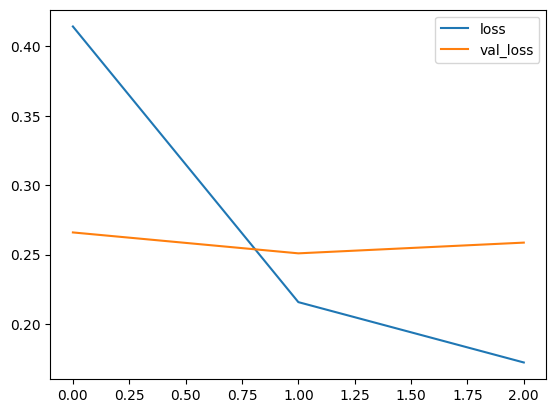

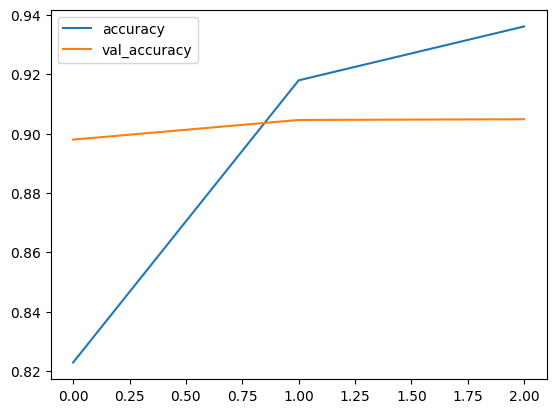

In [44]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'rnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 0

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

rnn_model.summary()

## Build a CNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple CNN model with a single `Conv1D` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model, but we need to add a `Flatten` layer betwen the convolution and the softmax layer.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


### Lab Task #4 and #6
Complete the code below to create a CNN model for text classification. This model is similar to the previous models in that you should start with an embedding layer. However, the embedding next layers should pass through a 1-dimensional convolution and ultimately the final fully connected, dense layer. Use the arguments of the `build_cnn_model` function to set up the 1D convolution layer. 

In [45]:
def build_cnn_model(embed_dim, filters, ksize, strides):
    
    model = Sequential([
        # Embedding layer to transform word integers into dense vectors
        # Setting mask_zero=True to ignore padded words (zeros)
        Embedding(input_dim=len(tokenizer.word_index) + 1,  # Vocabulary size + 1 (for padding)
                  output_dim=embed_dim,                     # Dimension of embedding vectors
                  mask_zero=True),                          # Mask padding tokens
        
        # 1D Convolutional layer to extract n-gram features
        Conv1D(filters=filters,                             # Number of output filters
               kernel_size=ksize,                           # Size of the convolution window
               strides=strides,                             # Stride length of the convolution
               activation='relu'),                          # Activation function
        
        # Flatten layer to convert the 2D feature maps to 1D feature vectors
        Flatten(),
        
        # Dense layer for classification (already provided)
        Dense(N_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Let's train the model. 

Again we observe that we get the same kind of accuracy as with the DNN model but in many fewer steps.



Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


857/857 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7381 - loss: 0.5791 - val_accuracy: 0.8971 - val_loss: 0.2638
Epoch 2/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9110 - loss: 0.2301 - val_accuracy: 0.9028 - val_loss: 0.2543
Epoch 3/100
857/857 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9334 - loss: 0.1773 - val_accuracy: 0.9024 - val_loss: 0.2622


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 26, 5)          │       517,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 12, 200)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         7,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,582,721 (6.04 MB)

 Trainable params: 527,573 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,055,148 (4.03 MB)

CPU times: user 1min 4s, sys: 4.24 s, total: 1min 8s
Wall time: 27.3 s


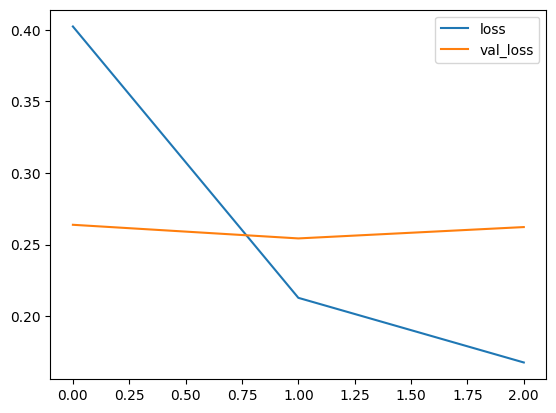

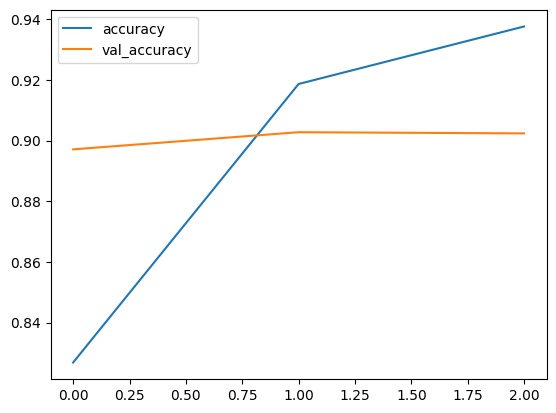

In [46]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'cnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 0


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

cnn_model.summary()

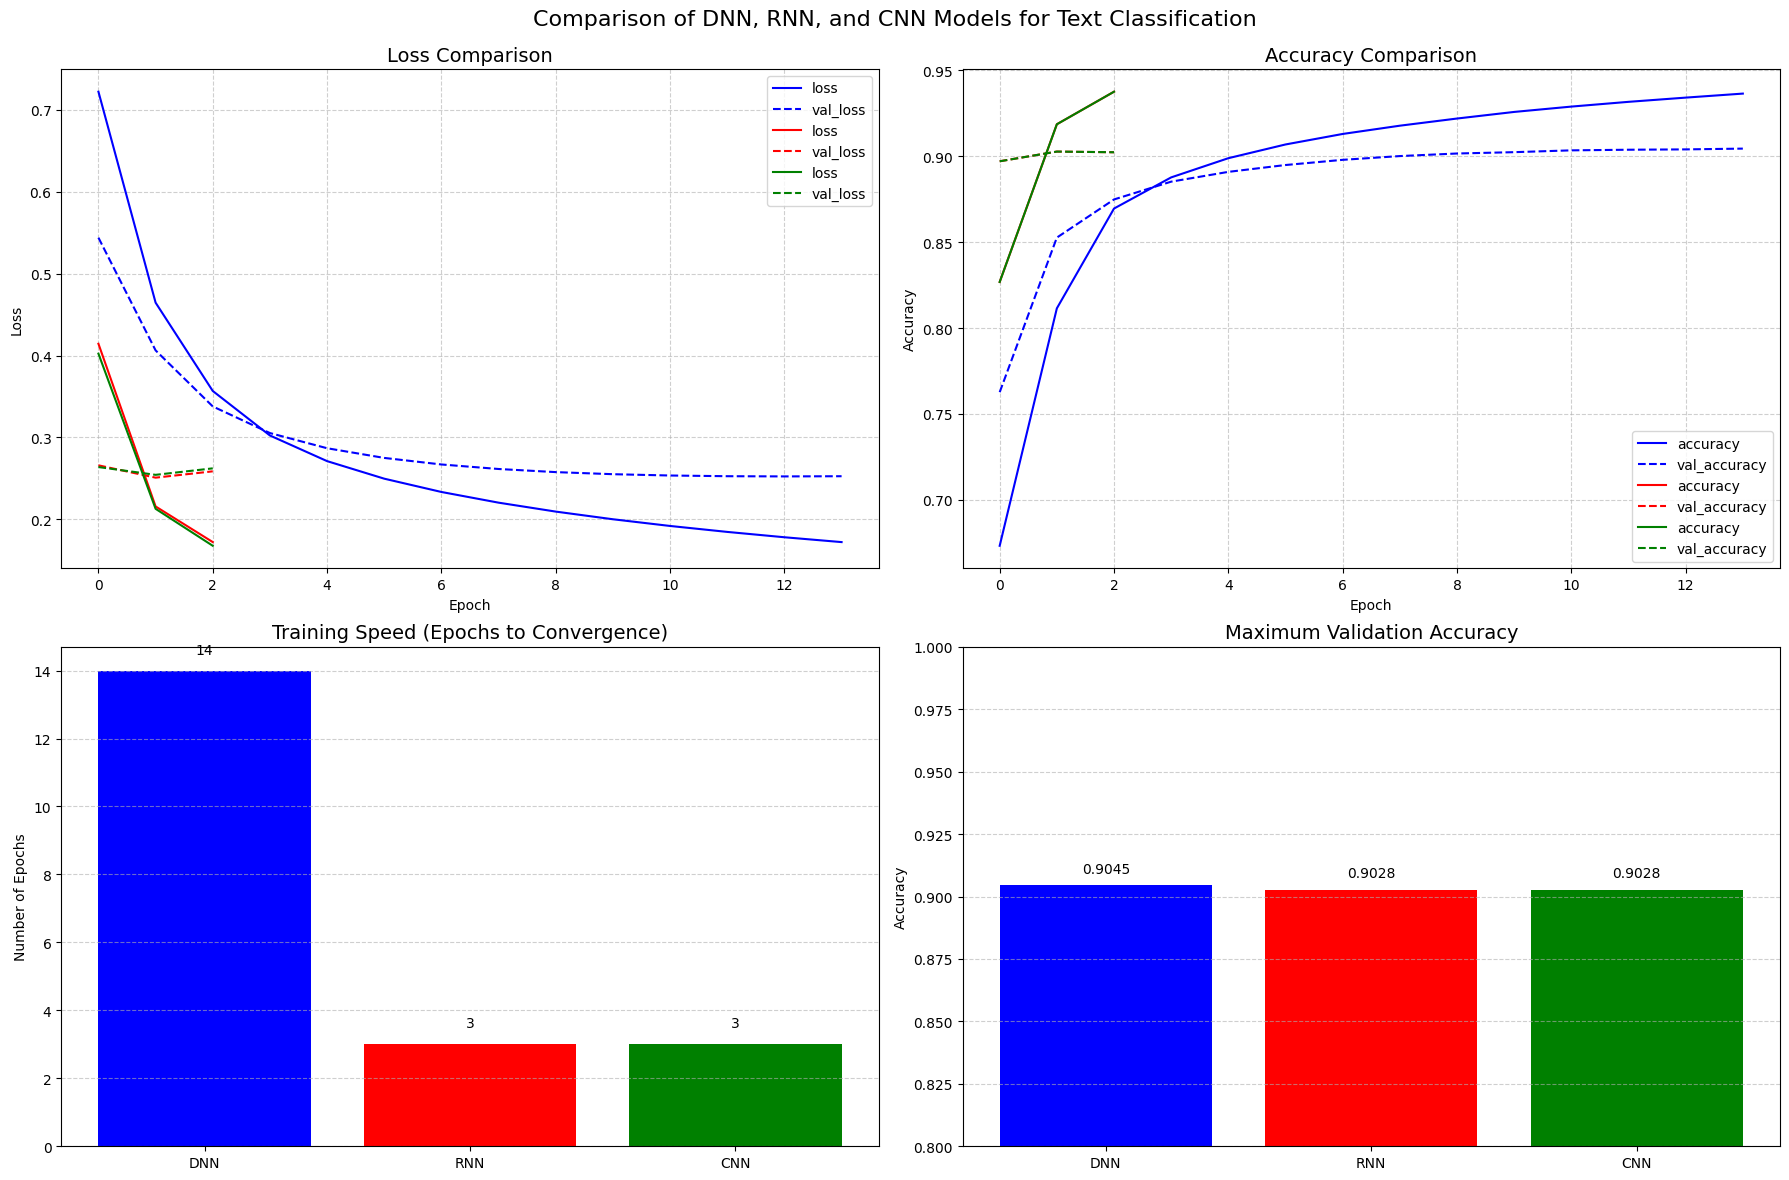

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Color coding for each model
colors = {'dnn': 'blue', 'rnn': 'red', 'cnn': 'green'}

# Loss comparison (top left)
for name, history in zip(['dnn', 'rnn', 'cnn'], [dnn_history, history, cnn_history]):
    pd.DataFrame(history.history)[['loss']].plot(
        ax=axes[0, 0], 
        label=f'{name.upper()} Training Loss',
        color=colors[name],
        style='-'
    )
    pd.DataFrame(history.history)[['val_loss']].plot(
        ax=axes[0, 0], 
        label=f'{name.upper()} Validation Loss',
        color=colors[name],
        style='--'
    )
axes[0, 0].set_title('Loss Comparison', fontsize=14)
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# Accuracy comparison (top right)
for name, history in zip(['dnn', 'rnn', 'cnn'], [dnn_history, history, cnn_history]):
    pd.DataFrame(history.history)[['accuracy']].plot(
        ax=axes[0, 1], 
        label=f'{name.upper()} Training Accuracy',
        color=colors[name],
        style='-'
    )
    pd.DataFrame(history.history)[['val_accuracy']].plot(
        ax=axes[0, 1], 
        label=f'{name.upper()} Validation Accuracy',
        color=colors[name],
        style='--'
    )
axes[0, 1].set_title('Accuracy Comparison', fontsize=14)
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# Training Speed (bottom left) - Number of epochs vs validation accuracy
epochs_to_max = {
    'DNN': len(dnn_history.history['val_accuracy']),
    'RNN': len(history.history['val_accuracy']),
    'CNN': len(cnn_history.history['val_accuracy'])
}
max_val_acc = {
    'DNN': max(dnn_history.history['val_accuracy']),
    'RNN': max(history.history['val_accuracy']),
    'CNN': max(cnn_history.history['val_accuracy'])
}

axes[1, 0].bar(epochs_to_max.keys(), epochs_to_max.values(), color=list(colors.values()))
axes[1, 0].set_title('Training Speed (Epochs to Convergence)', fontsize=14)
axes[1, 0].set_ylabel('Number of Epochs')
for i, v in enumerate(epochs_to_max.values()):
    axes[1, 0].text(i, v + 0.5, str(v), ha='center')
axes[1, 0].grid(True, linestyle='--', alpha=0.6, axis='y')

# Maximum validation accuracy (bottom right)
axes[1, 1].bar(max_val_acc.keys(), max_val_acc.values(), color=list(colors.values()))
axes[1, 1].set_title('Maximum Validation Accuracy', fontsize=14)
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim([0.8, 1.0])  # Set a reasonable y-axis limit
for i, v in enumerate(max_val_acc.values()):
    axes[1, 1].text(i, v + 0.005, f'{v:.4f}', ha='center')
axes[1, 1].grid(True, linestyle='--', alpha=0.6, axis='y')

plt.tight_layout()
plt.suptitle('Comparison of DNN, RNN, and CNN Models for Text Classification', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()


Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License